<a href="https://colab.research.google.com/github/JeongHanJun/Colab/blob/master/Image_Specification_CNN_TF_Keras_ver_2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
import pathlib
%matplotlib inline


In [ ]:
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = keras.utils.get_file('flower_photos', origin = dataset_url, untar = True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [ ]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


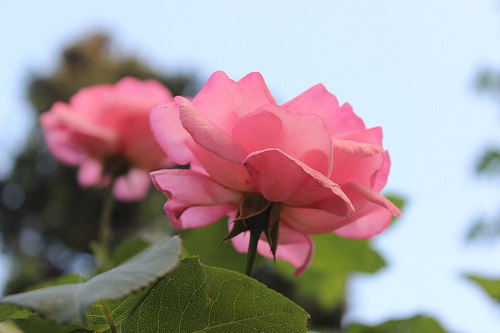

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

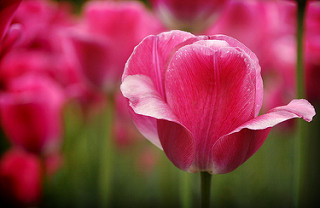

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[1]))

## Data Preprocessing

In [ ]:
my_batch_size = 32
my_epochs = 10
img_height = 180
img_width = 180

In [ ]:
train_datasets = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    batch_size = my_batch_size,
    image_size = (img_width, img_height),
    seed = 123,
    validation_split = 0.2,
    subset = "training"
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
# 3670 개의 데이터 중 2936 개가 train에 사용되고, 나머지 20%(734개)는 test에 사용한다.
val_datasets = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    batch_size = my_batch_size,
    image_size = (img_width, img_height),
    seed = 123,
    validation_split = 0.2,
    subset = "validation"
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_datasets.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
for image_batch, labels_batch in train_datasets:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
# 32개의 label에 대해 180x180 크기의 사진이 RGB(3)로 구성되어있다.

AUTOLINE = tf.data.experimental.AUTOTUNE

train_datasets = train_datasets.cache().shuffle(1000).prefetch(buffer_size = AUTOLINE)
val_datasets = val_datasets.cache().prefetch(buffer_size = AUTOLINE)


In [ ]:
normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)# 0 ~ 255 -> 0 ~ 1

In [ ]:
normalized_datasets = train_datasets.map(lambda x, y : (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_datasets))
first_image = image_batch[0]

print(np.min(first_image))
print(np.max(first_image))

0.0
1.0


## Model

In [ ]:
num_classes = 5

model = keras.Sequential([
    keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_width, img_height, 3)),
    keras.layers.Conv2D( filters = 16, kernel_size = 3, padding = "same", activation = 'relu' ),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D( filters = 32, kernel_size = 3, padding = "same", activation = 'relu' ),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D( filters = 64, kernel_size = 3, padding = "same", activation = 'relu' ),
    keras.layers.MaxPool2D(),

    keras.layers.Flatten(),
    keras.layers.Dense( 128, activation = 'relu' ),# units = 128
    keras.layers.Dense( num_classes )
])# 기존 MNIST 분류모델과 다른점 - MaxPool2D 에서 padding = "same" 을 하지 않음, Dense의 activation func = relu인 점 ( 기존에는 softmax 로 0~1 사이 비율로 리턴)

In [ ]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## 4. Train

In [ ]:
history = model.fit(
    train_datasets,
    validation_data = val_datasets,
    epochs = my_epochs
)

Epoch 1/10
92/92 [==============================] - 35s 37ms/step - loss: 1.3047 - accuracy: 0.4510 - val_loss: 1.1306 - val_accuracy: 0.5422
Epoch 2/10
92/92 [==============================] - 2s 20ms/step - loss: 1.0339 - accuracy: 0.5899 - val_loss: 0.9341 - val_accuracy: 0.6144
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 0.8320 - accuracy: 0.6809 - val_loss: 0.9178 - val_accuracy: 0.6417
Epoch 4/10
92/92 [==============================] - 2s 20ms/step - loss: 0.6376 - accuracy: 0.7534 - val_loss: 0.8590 - val_accuracy: 0.6676
Epoch 5/10
92/92 [==============================] - 2s 20ms/step - loss: 0.4093 - accuracy: 0.8604 - val_loss: 1.0137 - val_accuracy: 0.6499
Epoch 6/10
92/92 [==============================] - 2s 20ms/step - loss: 0.2279 - accuracy: 0.9278 - val_loss: 1.1612 - val_accuracy: 0.6499
Epoch 7/10
92/92 [==============================] - 2s 20ms/step - loss: 0.1108 - accuracy: 0.9690 - val_loss: 1.3862 - val_accuracy: 0.6526
Epoch 8/10
9

## Data Visualization

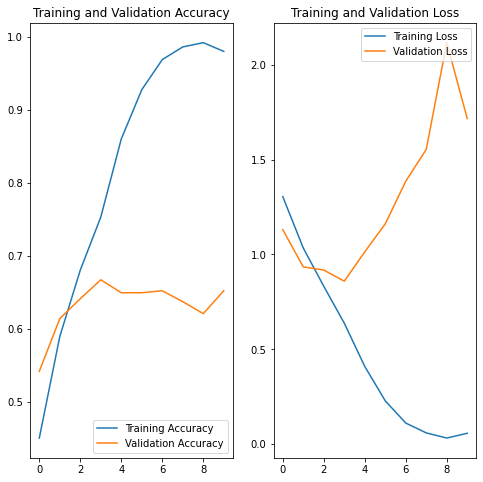

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(my_epochs)

plt.figure( figsize = (8, 8) )
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
'''
X_axis = epoch , Y-axis = Accuracy / Loss
Train / Validation 그래프 둘다 그래프의 차이가 심하다 -> "오버피팅"
학습할때 잘해도, 실제로 테스트해보니 잘 안된다
오버피팅에 대한 해결책이 필요하다.
'''
history.history

{'accuracy': [0.4509536921977997,
  0.5899182558059692,
  0.680858314037323,
  0.7534059882164001,
  0.8603542447090149,
  0.9277929067611694,
  0.9690054655075073,
  0.9863760471343994,
  0.9921662211418152,
  0.9802452325820923],
 'loss': [1.3047044277191162,
  1.0338674783706665,
  0.8320069909095764,
  0.637568473815918,
  0.40929582715034485,
  0.22792907059192657,
  0.11077309399843216,
  0.058911602944135666,
  0.03179670125246048,
  0.056827861815690994],
 'val_accuracy': [0.5422343611717224,
  0.6144413948059082,
  0.6416893601417542,
  0.667574942111969,
  0.6498637795448303,
  0.6498637795448303,
  0.6525885462760925,
  0.6376021504402161,
  0.6212534308433533,
  0.6525885462760925],
 'val_loss': [1.1305733919143677,
  0.9340832233428955,
  0.9177557229995728,
  0.8590294718742371,
  1.0137159824371338,
  1.1611864566802979,
  1.3861651420593262,
  1.5540050268173218,
  2.1167144775390625,
  1.7164431810379028]}

## Solve Overfitting

### 1. Data Augmentation ( 데이터 증강 )
      - 오버피팅의 원인중 하나인, 다양한 데이터(이미지)가 없는 문제를 해결하기 위한 방법
      - 데이터 증강은 한개의 데이터에 대해 회전하거나 좌우 반전을 하는등의 방법으로 다양한 데이터를 생성한다.
      - 실제 데이터 원본에는 손상을 주지 않고 데이터의 갯수를 늘리는 방법이다.

In [ ]:
data_augmentation = keras.Sequential(
    [
     keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape = (img_width, img_height, 3)),
     keras.layers.experimental.preprocessing.RandomRotation(0.1),
     keras.layers.experimental.preprocessing.RandomZoom(0, 1),

    ]
)

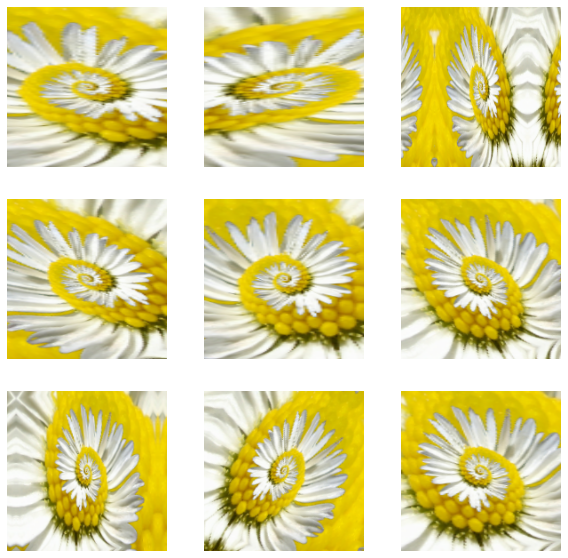

In [ ]:
plt.figure(figsize = (10, 10))
for images, _ in train_datasets.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### 2. DropOut
      - 오버피팅의 원인중에 비슷한 데이터는 항상 같은 방식으로 학습하기 때문인 점을 해결하기 위함
      - Random하게 몇개의 가중치(Weight)에 대해 비활성화 시키는 방법
      - 최근에는 배치정규화 라는 방법을 사용하는데, 그때는 DropOut 방법을 사용하지 않는다.

In [ ]:
model = keras.Sequential(
    [
     data_augmentation,
     keras.layers.experimental.preprocessing.Rescaling(1./255),
     keras.layers.Conv2D( filters = 16 , kernel_size = 3 , padding = "same", activation = 'relu' ),
     keras.layers.MaxPool2D(),
     keras.layers.Conv2D( filters = 32, kernel_size = 3, padding = "same", activation = "relu" ),
     keras.layers.MaxPool2D(),
     keras.layers.Conv2D( filters = 64, kernel_size = 3, padding = "same", activation = "relu" ),
     keras.layers.MaxPool2D(),

     keras.layers.Dropout(0.2),
     keras.layers.Flatten(),
     keras.layers.Dense( 128, activation = 'relu' ),
     keras.layers.Dense(num_classes),
    ]
)
# model 안에 기존에 만들었던 model을 넣을 수 있다. 이게 바로 Tensorflow

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [ ]:
new_epochs = 15
new_history = model.fit(
    train_datasets,
    validation_data = val_datasets,
    epochs = new_epochs
)

Epoch 1/15
92/92 [==============================] - 3s 25ms/step - loss: 1.3927 - accuracy: 0.3839 - val_loss: 1.1581 - val_accuracy: 0.4946
Epoch 2/15
92/92 [==============================] - 2s 23ms/step - loss: 1.0960 - accuracy: 0.5579 - val_loss: 1.3040 - val_accuracy: 0.4700
Epoch 3/15
92/92 [==============================] - 2s 23ms/step - loss: 0.9980 - accuracy: 0.6035 - val_loss: 1.0860 - val_accuracy: 0.5804
Epoch 4/15
92/92 [==============================] - 2s 23ms/step - loss: 0.9269 - accuracy: 0.6356 - val_loss: 0.9260 - val_accuracy: 0.6390
Epoch 5/15
92/92 [==============================] - 2s 23ms/step - loss: 0.8921 - accuracy: 0.6543 - val_loss: 0.8477 - val_accuracy: 0.6717
Epoch 6/15
92/92 [==============================] - 2s 23ms/step - loss: 0.8467 - accuracy: 0.6815 - val_loss: 0.8087 - val_accuracy: 0.6757
Epoch 7/15
92/92 [==============================] - 2s 23ms/step - loss: 0.8186 - accuracy: 0.6887 - val_loss: 0.7889 - val_accuracy: 0.7044
Epoch 8/15
92

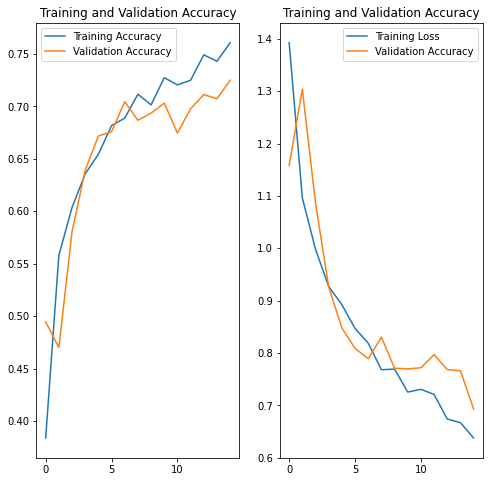

In [ ]:
acc = new_history.history['accuracy']
val_acc = new_history.history['val_accuracy']

loss = new_history.history['loss']
val_loss = new_history.history['val_loss']

epochs_range = range(new_epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label =  'Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

### Solve Overfitting 
- 확실히 Train 과 Validation 의 차이가 줄어들었다.
- 기존의 model보다 성능이 더 좋아진 것을 알 수 있다.
- 위의 2가지 내용을 통해 Overfitting을 극복한 것을 알 수 있다.

## Prediction (예측)

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = keras.utils.get_file('Red_sunflower', origin = sunflower_url)

loaded_img = keras.preprocessing.image.load_img(
    sunflower_path, target_size = (img_width, img_height)
)

loaded_img_arr = keras.preprocessing.image.img_to_array(loaded_img)
loaded_img_arr = tf.expand_dims(loaded_img_arr, 0)# create a batch

predictions = model.predict(loaded_img_arr)
score = tf.nn.softmax(predictions[0])

print(
    'This image most likely belongs to {} with a {:.2f} percent confidence'.format( class_names[np.argmax(score)], 100 * np.max(score) )
)

122880/117948 [===============================] - 0s 0us/step
This image most likely belongs to sunflowers with a 87.68 percent confidence


In [ ]:
test1_url = 'https://images.wsj.net/im-330778?width=1280&size=1.jpg'
test1_path = keras.utils.get_file('test1', origin = test1_url)

loaded_img = keras.preprocessing.image.load_img(
    test1_path, target_size = (img_width, img_height)
)

test1_img_arr = keras.preprocessing.image.img_to_array(loaded_img)
test1_img_arr = tf.expand_dims(test1_img_arr, 0)# create a batch  (x, y, c) -> (b, x, y, c)

predictions = model.predict(test1_img_arr)
score = tf.nn.softmax(predictions[0])

print(
    'This image most likely belongs to {} with a {:.2f} percent confidence'.format( class_names[np.argmax(score)], 100 * np.max(score) )
)

188416/180613 [===============================] - 0s 0us/step
This image most likely belongs to roses with a 65.77 percent confidence


In [ ]:
test2_url = 'https://media.istockphoto.com/photos/daisy-on-a-white-background-picture-id890573264'
test2_path = keras.utils.get_file('test2', origin = test2_url)

test2_img = keras.preprocessing.image.load_img(
    test2_path, target_size = (img_width, img_height)
)

test2_img_arr = keras.preprocessing.image.img_to_array(test2_img)
test2_img_arr = tf.expand_dims(test2_img_arr, 0)

predictions = model.predict(test2_img_arr)
score = tf.nn.softmax(predictions[0])

print(
    "This Image most likely belongs to {} with a {:.2f} percent confidence".format(class_names[np.argmax(score)], 100 * np.max(score))
)

This Image most likely belongs to roses with a 50.13 percent confidence
